# 1. Imports & Config

In [30]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from transformers import BertTokenizer, BertModel

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [ ]:
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_DIR   = "/kaggle/input/flickr8k/Images"
CAPTION_FILE= "/kaggle/input/flickr8k/captions.txt"

BATCH_SIZE  = 32
EMBED_DIM   = 512
MASK_RATIO  = 0.30
MAX_SAMPLES = 15000

In [45]:
LR = 3e-5

# 2. Load Flickr Captions

In [34]:
def load_captions(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        next(f)
        for line in f:
            parts = line.strip().split(",", 1)
            if len(parts) == 2:
                data.append((parts[0], parts[1]))
    return data

pairs = load_captions(CAPTION_FILE)
pairs = pairs[:MAX_SAMPLES]

print("Total samples:", len(pairs))

Total samples: 15000


# 3. Dataset

In [35]:
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std =[0.229,0.224,0.225]
    )
])

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [36]:
class FlickrDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, caption = self.pairs[idx]

        img_path = os.path.join(IMAGE_DIR, img_name)
        image = Image.open(img_path).convert("RGB")
        image = image_transform(image)

        tokens = tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )

        return (
            image,
            tokens["input_ids"].squeeze(0),
            tokens["attention_mask"].squeeze(0)
        )

dataset = FlickrDataset(pairs)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4. Models (JEPA Modules)

# X-Encoder

In [37]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        base.fc = nn.Identity()
        self.backbone = base
        self.fc = nn.Linear(512, embed_dim)

    def forward(self, x):
        x = self.backbone(x)
        return self.fc(x)

# Y-Encoder

In [38]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc   = nn.Linear(768, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls = outputs.last_hidden_state[:,0]
        return self.fc(cls)

# Predictor (Context → Target)

In [39]:
class Predictor(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, embed_dim)
        )

    def forward(self, x):
        return self.net(x)

# 5. Masking Function (JEPA Core)

In [46]:
def mask_tokens(input_ids, attention_mask, mask_ratio=0.03):
    input_ids = input_ids.clone()
    B, T = input_ids.shape

    for i in range(B):
        valid_pos = torch.where(attention_mask[i] == 1)[0]
        valid_pos = valid_pos[valid_pos != 0]  # avoid CLS

        n_mask = max(1, int(len(valid_pos) * mask_ratio))
        mask_pos = valid_pos[torch.randperm(len(valid_pos))[:n_mask]]

        input_ids[i, mask_pos] = tokenizer.mask_token_id

    return input_ids

# 6. InfoNCE Loss

In [47]:
def info_nce_loss(z_pred, z_true, temperature=0.07):
    z_pred = F.normalize(z_pred, dim=1)
    z_true = F.normalize(z_true, dim=1)

    logits = torch.matmul(z_pred, z_true.T) / temperature
    labels = torch.arange(z_pred.size(0)).to(z_pred.device)

    return F.cross_entropy(logits, labels)

# 7. Initialize Models

In [48]:
image_encoder = ImageEncoder(EMBED_DIM).to(DEVICE)
text_encoder  = TextEncoder(EMBED_DIM).to(DEVICE)
predictor     = Predictor(EMBED_DIM).to(DEVICE)

params = (
    list(image_encoder.parameters()) +
    list(text_encoder.parameters()) +
    list(predictor.parameters())
)

optimizer = torch.optim.Adam(params, lr=LR)

In [55]:
EPOCHS = 15

# 8. Training Loop (Masked JEPA)

In [56]:
for epoch in range(EPOCHS):
    total_loss = 0.0

    for images, input_ids, masks in tqdm(loader):
        images    = images.to(DEVICE)
        input_ids = input_ids.to(DEVICE)
        masks     = masks.to(DEVICE)

        
        # Encode image
        z_img = image_encoder(images)

        
        # Mask text tokens
        masked_ids = mask_tokens(input_ids, masks, MASK_RATIO)

        
        # Encode masked text (context) and full text (target)
        # Target encoder is frozen for stability
        with torch.no_grad():
            z_txt_masked = text_encoder(masked_ids, masks)
            z_txt_full   = text_encoder(input_ids, masks)

        
        # Normalize before fusion
        z_img = F.normalize(z_img, dim=1)
        z_txt_masked = F.normalize(z_txt_masked, dim=1)

        
        # Fuse context
        z_context = torch.cat([z_img, z_txt_masked], dim=1)

        
        # Predict target embedding
        z_pred = predictor(z_context)

        
        # Loss (InfoNCE in embedding space)
        loss = info_nce_loss(z_pred, z_txt_full)

        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}]  Total Loss: {total_loss:.3f}")

100%|██████████| 469/469 [03:16<00:00,  2.39it/s]


Epoch [1/15]  Total Loss: 449.928


100%|██████████| 469/469 [03:12<00:00,  2.43it/s]


Epoch [2/15]  Total Loss: 421.675


100%|██████████| 469/469 [03:13<00:00,  2.42it/s]


Epoch [3/15]  Total Loss: 404.402


100%|██████████| 469/469 [03:14<00:00,  2.42it/s]


Epoch [4/15]  Total Loss: 393.182


100%|██████████| 469/469 [03:13<00:00,  2.43it/s]


Epoch [5/15]  Total Loss: 384.862


100%|██████████| 469/469 [03:14<00:00,  2.42it/s]


Epoch [6/15]  Total Loss: 375.668


100%|██████████| 469/469 [03:13<00:00,  2.42it/s]


Epoch [7/15]  Total Loss: 368.077


100%|██████████| 469/469 [03:14<00:00,  2.42it/s]


Epoch [8/15]  Total Loss: 361.769


100%|██████████| 469/469 [03:13<00:00,  2.42it/s]


Epoch [9/15]  Total Loss: 355.675


100%|██████████| 469/469 [03:11<00:00,  2.44it/s]


Epoch [10/15]  Total Loss: 351.769


100%|██████████| 469/469 [03:11<00:00,  2.45it/s]


Epoch [11/15]  Total Loss: 345.454


100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


Epoch [12/15]  Total Loss: 341.760


100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


Epoch [13/15]  Total Loss: 335.984


100%|██████████| 469/469 [03:13<00:00,  2.42it/s]


Epoch [14/15]  Total Loss: 333.437


100%|██████████| 469/469 [03:15<00:00,  2.40it/s]

Epoch [15/15]  Total Loss: 332.427


Increasing Epoch will give better results

# 9. Collect Embeddings

In [57]:
def collect_embeddings(loader):
    image_encoder.eval()
    predictor.eval()
    text_encoder.eval()

    Z_pred, Z_txt = [], []

    with torch.no_grad():
        for images, input_ids, masks in tqdm(loader):
            images   = images.to(DEVICE)
            input_ids= input_ids.to(DEVICE)
            masks    = masks.to(DEVICE)

            z_img = image_encoder(images)
            z_txt = text_encoder(input_ids, masks)

            z_context = torch.cat([z_img, z_txt], dim=1)
            z_pred = predictor(z_context)

            Z_pred.append(z_pred.cpu().numpy())
            Z_txt.append(z_txt.cpu().numpy())

    return np.vstack(Z_pred), np.vstack(Z_txt)

Z_pred, Z_txt = collect_embeddings(loader)
print("Embedding shapes:", Z_pred.shape, Z_txt.shape)

100%|██████████| 469/469 [02:06<00:00,  3.70it/s]


Embedding shapes: (15000, 512) (15000, 512)


# 10. Evaluation

# Similarity Distribution

Mean similarity: 0.27087724
Std similarity : 0.06826503


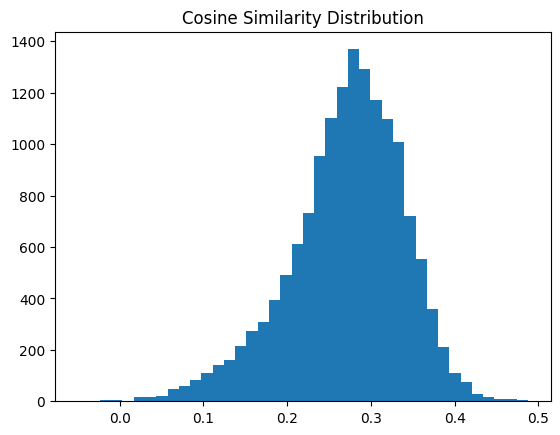

In [58]:
sims = np.array([
    cosine_similarity(Z_pred[i].reshape(1,-1),
                      Z_txt[i].reshape(1,-1))[0][0]
    for i in range(len(Z_pred))
])

print("Mean similarity:", sims.mean())
print("Std similarity :", sims.std())

plt.hist(sims, bins=40)
plt.title("Cosine Similarity Distribution")
plt.show()

# Recall@K

In [59]:
def recall_at_k(Z_pred, Z_txt, K=5):
    sims = cosine_similarity(Z_pred, Z_txt)
    correct = 0

    for i in range(len(Z_pred)):
        top_k = np.argsort(sims[i])[::-1][:K]
        if i in top_k:
            correct += 1

    return correct / len(Z_pred)

for k in [1,3,5,10]:
    print(f"Recall@{k}: {recall_at_k(Z_pred, Z_txt, k):.3f}")

Recall@1: 0.030
Recall@3: 0.066
Recall@5: 0.089
Recall@10: 0.134


# t-SNE Visualization

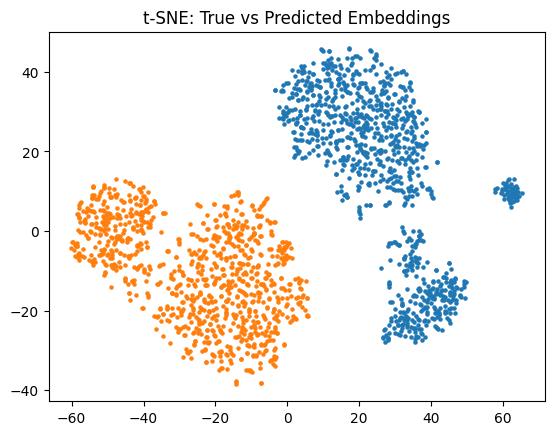

In [60]:
from sklearn.manifold import TSNE

N = 1000
Z_vis = np.vstack([Z_txt[:N], Z_pred[:N]])
labels = np.array([0]*N + [1]*N)

tsne = TSNE(n_components=2, perplexity=30)
Z_2d = tsne.fit_transform(Z_vis)

plt.scatter(Z_2d[labels==0,0], Z_2d[labels==0,1], s=5)
plt.scatter(Z_2d[labels==1,0], Z_2d[labels==1,1], s=5)
plt.title("t-SNE: True vs Predicted Embeddings")
plt.show()

### We Can Train for More Epochs to get better results , as training this model needs huge GPU Support . As earlier we trained our model for 5 epochs , there the two clusters of actual and predicted were more far apart . After training for 15 epochs and decreasing masking % , we can see the clusteers are more close, although this is  not a good result , but insreasing the number of epochs will give better results .